<a href="https://colab.research.google.com/github/crislmfroes/pytorch-colab-notebooks/blob/master/classificador_de_abelhas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [5]:
!pip install torch torchvision

    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61600000 @  0x7f8abcd292a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 23.9MB/s 
    100% |████████████████████████████████| 2.0MB 4.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
from torch.utils.data import Dataset, DataLoader

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import time
import copy

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [0]:
root_dir = './drive/My Drive/Datasets/honey-bee-pollen/PollenDataset/'

In [0]:
data_frame = pd.read_csv(root_dir + 'pollen_data.csv', index_col=0)

In [7]:
data_frame[None:5]

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0


In [39]:
np.zeros((2))

array([0., 0.])

In [0]:
class PollenDataset(Dataset):
  def __init__(self, root_dir, csv_file, transform=None, start=None, end=None):
    self.data_frame = pd.read_csv(root_dir + csv_file)[start:end]
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return len(self.data_frame)
  def __getitem__(self, idx):
    path = os.path.join(self.root_dir, 'images', self.data_frame.iloc[idx, 1])
    img = Image.open(path)
    #pollen_array = np.zeros((2))
    is_pollen = self.data_frame.iloc[idx, 2]
    #pollen_array[is_pollen] = 1
    #pollen_carrying = torch.tensor(is_pollen, dtype=torch.float32)
    sample = {'image': img, 'pollen_carrying': is_pollen}
    if self.transform:
      sample['image'] = self.transform(sample['image'])
    return sample

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [0]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [0]:
eval_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [0]:
train_dataset = PollenDataset(root_dir, 'pollen_data.csv', transform=train_transforms, end=700)

In [0]:
eval_dataset = PollenDataset(root_dir, 'pollen_data.csv', transform=eval_transforms, start=700)

In [0]:
dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
dataloader_eval = DataLoader(eval_dataset, batch_size=64, shuffle=True, num_workers=4)

In [0]:
dataloader = {
    'train': dataloader_train,
    'eval': dataloader_eval
}

In [0]:
dataset_sizes = {
    'train': len(train_dataset),
    'eval': len(eval_dataset)
}

In [0]:
def train(model, criterion, optimizer, scheduler, n_epochs=25):
  start = time.time()
  best_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(n_epochs):
    print('Epoch: {}/{}'.format(epoch, n_epochs - 1))
    print('+'*10)
    for phase in ['train', 'eval']:
      if phase == 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()
      current_loss = 0.0
      current_corrects = 0
      for sample in dataloader[phase]:
        inputs = sample['image']
        labels = sample['pollen_carrying']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        current_loss += loss.item() * inputs.size(0)
        current_corrects += torch.sum(preds == labels)
      epoch_loss = current_loss / dataset_sizes[phase]
      epoch_acc = current_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f}, Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))
      if phase == 'eval' and epoch_acc >= best_acc:
        best_acc = epoch_acc
        best_weights = copy.deepcopy(model.state_dict())
    print()
  time_elapsed = time.time() - start
  print('Training comp-lete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_weights)
  return model

In [0]:
model_resnet = models.resnet18(pretrained=True).float()
n_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(n_features, 2)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [105]:
model_resnet = train(model_resnet, criterion, optimizer, exp_lr_scheduler, n_epochs=25)

Epoch: 0/24
++++++++++
train Loss: 0.6626, Acc: 0.7157%
eval Loss: 1.2195, Acc: 0.7143%

Epoch: 1/24
++++++++++
train Loss: 0.3194, Acc: 0.8543%
eval Loss: 3.2918, Acc: 0.7143%

Epoch: 2/24
++++++++++
train Loss: 0.3131, Acc: 0.8471%
eval Loss: 0.9464, Acc: 0.8571%

Epoch: 3/24
++++++++++
train Loss: 0.2913, Acc: 0.8614%
eval Loss: 0.2962, Acc: 0.8571%

Epoch: 4/24
++++++++++
train Loss: 0.2403, Acc: 0.9014%
eval Loss: 0.2958, Acc: 0.8571%

Epoch: 5/24
++++++++++
train Loss: 0.2469, Acc: 0.8971%
eval Loss: 0.4082, Acc: 0.8571%

Epoch: 6/24
++++++++++
train Loss: 0.2368, Acc: 0.9000%
eval Loss: 0.0548, Acc: 1.0000%

Epoch: 7/24
++++++++++
train Loss: 0.1981, Acc: 0.9129%
eval Loss: 0.0277, Acc: 1.0000%

Epoch: 8/24
++++++++++
train Loss: 0.1905, Acc: 0.9257%
eval Loss: 0.0308, Acc: 1.0000%

Epoch: 9/24
++++++++++
train Loss: 0.1933, Acc: 0.9086%
eval Loss: 0.0450, Acc: 1.0000%

Epoch: 10/24
++++++++++
train Loss: 0.1818, Acc: 0.9257%
eval Loss: 0.0898, Acc: 0.9286%

Epoch: 11/24
+++++++

In [0]:
def imshow(image, title=None):
  image = image.numpy().transpose((1, 2, 0))
  image = np.array(std) * image + np.array(mean)
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [0]:
def show_model(model, n_images=6):
  was_training = model.training
  model.eval()
  fig = plt.figure()
  total_images = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader['eval']):
      inputs = data['image'].to(device)
      labels = data['pollen_carrying'].to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.size()[0]):
        total_images += 1
        ax = plt.subplot(n_images // 2, 2, total_images)
        ax.axis('off')
        ax.set_title('Predicted pollen: {}, Ground truth: {}'.format('yes' if preds[j] == 1 else 'no', 'yes' if labels[j] == 1 else 'no'))
        imshow(inputs.cpu().data[j])
        if total_images == n_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [0]:
plt.ion()

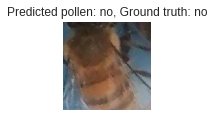

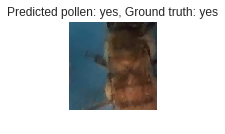

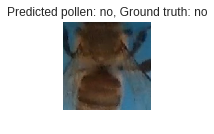

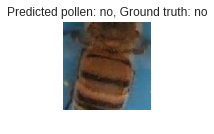

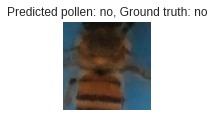

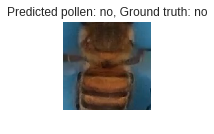

In [111]:
show_model(model_resnet, n_images=6)

In [0]:
torch.save(model_resnet.state_dict(), './drive/My Drive/PyTorch/Models/bee_pollen_classifier.pth')